# ANALIZAMOS LA INFORMACIÓN DEL AYUNTAMIENTO DE MADRID PARA OBTENER UNA PREDICCIÓN DE LA CARGA DE TRÁFICO EN LA M30


CARGAMOS LAS LIBRERIAS DE PYTHON

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

CARGAMOS LAS SERIES TEMPORALES Y SELECCIONAMOS EL PUNTO CON MAS CARGA DE LA M30

In [2]:
df = pd.read_csv('F:/201711_dataton_opendata_madrid/dat/201704_DatosTrafico.csv')
df = df[df.tipo_elem == 'PUNTOS MEDIDA M-30']
temp = df.groupby(['identif'], sort=False)['carga'].mean().sort_values(ascending=False).reset_index()
M30_PUNTO = temp['identif'][0]
M30_PUNTO


'PM20976'

CARGAMOS LAS VACACIONES Y LES INCLUIMOS EL EFECTO SOBRE DIAS ANTERIORES Y POSTERIORES

In [3]:
hol = pd.read_csv('F:/201711_dataton_opendata_madrid/dat/calendario_2013_2018.csv',
                  encoding='utf-8',
                  sep= ';')
columnas = ['Dia', 'Festividad']
hol=hol[columnas]
hol.rename(columns={'Dia': 'ds', 'Festividad': 'holiday'}, inplace=True)
hol=hol[hol.holiday.notnull()]
hol['lower_window']=-1
hol['upper_window']=0
hol[0:5]



,ds,holiday,lower_window,upper_window
0,01/01/2013,AnioNuevo,-1,0
6,07/01/2013,Epifania del Senior,-1,0
76,18/03/2013,San Jose,-1,0
86,28/03/2013,Jueves Santo,-1,0
87,29/03/2013,Viernes Santo,-1,0


PREPARAMOS UNA TABLA CON EL PUNTO A ANALIZAR EN LA SERIE TEMPORAL


In [4]:
tmp_df = df[df.identif==M30_PUNTO]
columnas = ['identif', 'fecha','carga']
tmp_df=tmp_df[columnas]

tmp_df.rename(columns={'fecha': 'ds', 'carga': 'y'}, inplace=True)
tmp_df['cap'] = 100
#tmp_df['floor'] = 0
tmp_df[1:5]

,identif,ds,y,cap
437,PM20976,2017-04-14 14:45:00,60,100
1326,PM20976,2017-04-19 20:30:00,93,100
1488,PM20976,2017-04-04 00:00:00,28,100
1508,PM20976,2017-04-16 08:00:00,29,100


EJECUTAMOS EL MODELO CON LAS CARACTERISTICAS:

    - growth = 'logistic'. Entendemos que el crecimiento no es líneal si no que tiene un punto de saturación
    - changepoint_prior_scale=0.5 Flexibilidad del modelo buscando puntos de cambio (incrementarlo flexibiliza el modelo)
    - changepoints = c('2014-01-01') Permite determinar puntos de cambio si se conocen.
    - interval_width=0.80 Controla el nivel de incertidumbre de los intervalos de confianza
    - seasonality_prior_scale: regularización de la estacionalidad (anual y semanal)(entre 0.01 y 10)
    - holidays_prior_scale: regularización de los festivos
    

In [24]:
model=Prophet(growth = 'logistic',
              yearly_seasonality=False,
              weekly_seasonality='auto',
              daily_seasonality='auto',
              changepoint_prior_scale=0.5,
              seasonality_prior_scale = 10,
              holidays=hol,
              holidays_prior_scale = 5,
              interval_width=0.90)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(tmp_df)

Obtenemos la predicción 

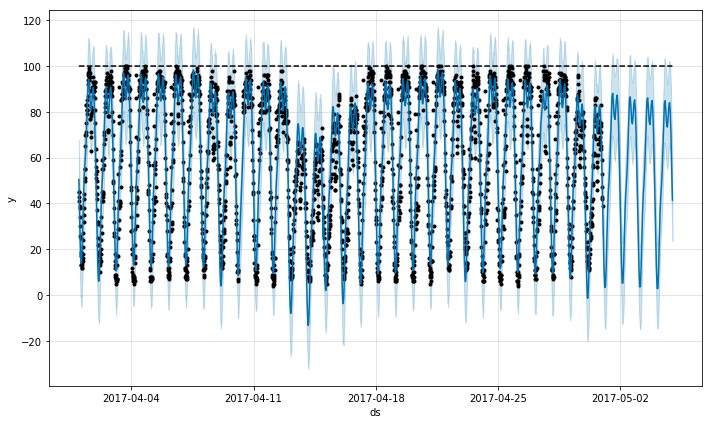

In [25]:
future = model.make_future_dataframe(periods=24*4, freq='H')
future['cap'] = 100
#future['floor'] = 0
forecast = model.predict(future)
model.plot(forecast)

DESAGREGAMOS LOS COMPONENTES


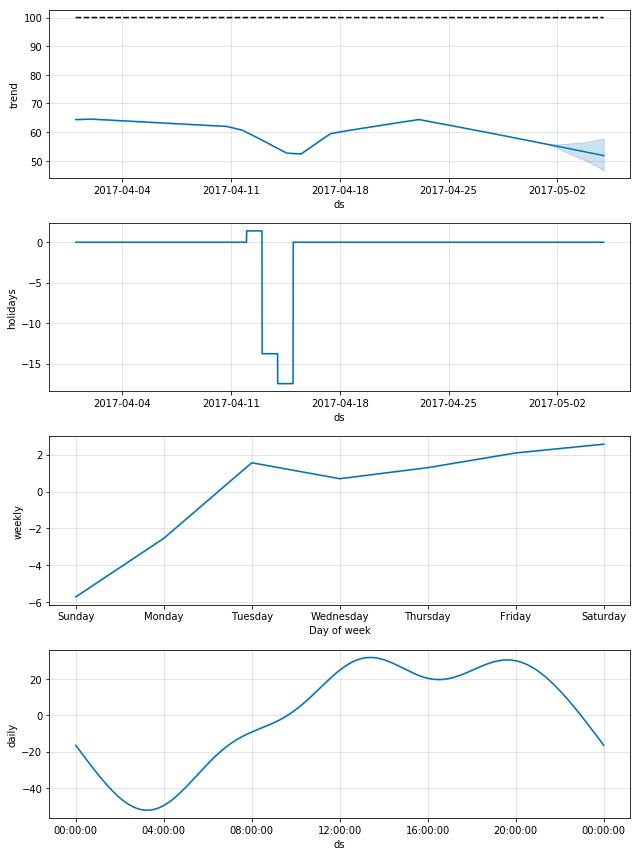

In [26]:
model.plot_components(forecast)

CROSSVALIDATION


In [27]:
df_cv = cross_validation(model, horizon = '7 days')
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
653,2017-04-30 22:45:00,76.094693,55.388305,95.177065,53,2017-04-23 23:45:00
654,2017-04-30 23:00:00,72.507121,53.680851,92.896366,47,2017-04-23 23:45:00
655,2017-04-30 23:15:00,68.824641,48.672503,87.054042,42,2017-04-23 23:45:00
656,2017-04-30 23:30:00,65.067045,45.330550,84.552744,43,2017-04-23 23:45:00
657,2017-04-30 23:45:00,61.254425,42.287869,80.651398,39,2017-04-23 23:45:00


In [28]:
RMSE_Yhat = ((df_cv.y - df_cv.yhat) ** 2).mean() ** .5
RMSE_Yhat_lower = ((df_cv.y - df_cv.yhat_lower) ** 2).mean() ** .5
RMSE_Yhat_upper = ((df_cv.y - df_cv.yhat_upper) ** 2).mean() ** .5
print('RMSE_Yhat:',RMSE_Yhat)
print('RMSE_Yhat_lower:',RMSE_Yhat_lower)
print('RMSE_Yhat_upper:',RMSE_Yhat_upper)

RMSE_Yhat: 16.303322343026284
RMSE_Yhat_lower: 13.917902291662056
RMSE_Yhat_upper: 31.925765317386123
